<a href="https://colab.research.google.com/github/mickeykim70/keras_study/blob/main/8_2_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare drive and data

In [1]:
# 1. Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle
!mkdir -p ~/.kaggle

Mounted at /content/drive


In [2]:
# 2. Kaggle API 설정

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:13<00:00, 25.6MB/s]
100% 812M/812M [00:13<00:00, 62.7MB/s]


In [3]:
!unzip -qq dogs-vs-cats.zip

In [4]:
!unzip -qq test1.zip

In [5]:
!unzip -qq train.zip

## Split data from original data

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## Instantiate a small convnet

In [8]:
import keras
from keras import layers

### Layers

In [9]:
# The model expects RGB images (180X180)
inputs = keras.Input(shape=(180,180,3), name="input Layer")

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input Layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compile

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Data Preprocessing
`image_dataset_from_directory` : 디렉토리 이미지 파일을 색인화, 셔플, 텐서로 디코딩, 공유크기로 크기 조정할 수 있는 tf.data.Dataset개체를 반환

In [14]:
from keras.utils import image_dataset_from_directory

In [15]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

vaildation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
import numpy as np
import tensorflow as tf

In [24]:
random_numbers = np.random.normal(size=(1000,16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [25]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i>=2:
        break

(16,)
(16,)
(16,)


In [26]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i>=2:
        break

(32, 16)
(32, 16)
(32, 16)


## Fitting the model using a Dataset

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=vaildation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.4965 - loss: 0.7104 - val_accuracy: 0.5100 - val_loss: 0.6923
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.5174 - loss: 0.6996 - val_accuracy: 0.5000 - val_loss: 0.7147
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.5529 - loss: 0.6925 - val_accuracy: 0.5840 - val_loss: 0.6728
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.5788 - loss: 0.6813 - val_accuracy: 0.6260 - val_loss: 0.6644
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.6248 - loss: 0.6520 - val_accuracy: 0.5900 - val_loss: 0.6604
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6508 - loss: 0.6170 - val_accuracy: 0.6270 - val_loss: 0.6267
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6928 - loss: 0.5909 - val_accuracy: 0.6460 - val_loss: 0.6097
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7055 - loss: 0.5612 - val_accuracy: 0.6520

## Display curves of loss and acc during training

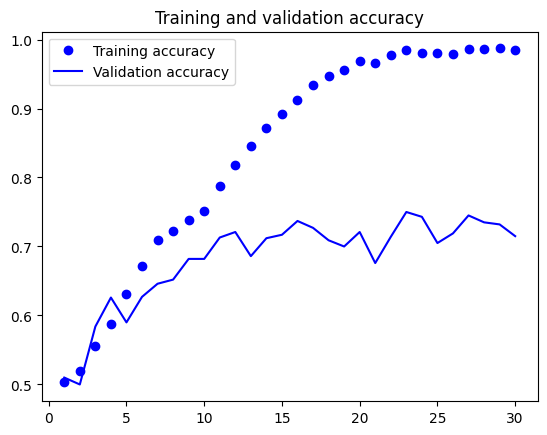

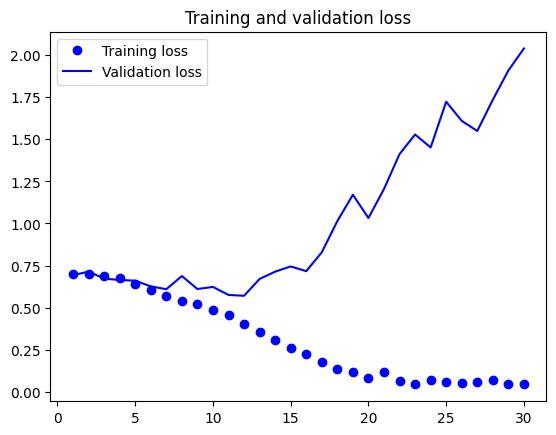

In [28]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()